In [2]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model,Sequential
from keras.layers import Input,Dense, Dropout, Activation, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers.pooling import GlobalAveragePooling2D
from keras.layers import Embedding
from keras import regularizers
from keras.losses import mean_squared_error
import glob
import matplotlib.patches as patches
import json
import numpy as np
from matplotlib.path import Path
import dicom
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.
/Users/sharonedayan/tensorflow/lib/python3.5/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


The second step of the algorithm is to train a stacked Auto-encoder in order to get the binary mask of the left ventricule inferred shape within the ROI (region of interest output of CNN). It is performed in two steps : pre-training then fine-tuning.

## Open DataSet

Dataset shape : (495, 64, 64, 1) (495, 1, 32, 32)


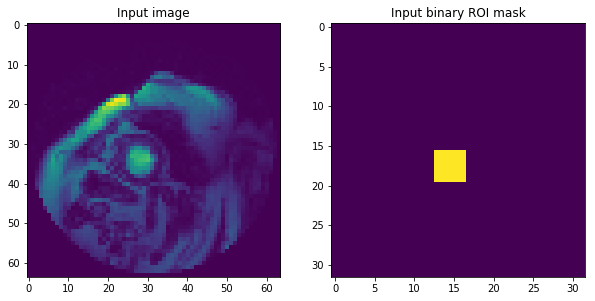

Size for each layer :
Layer, Input Size, Output Size
Conv2D_1 (None, 64, 64, 1) (None, 54, 54, 100)
Average_Pooling2D_1 (None, 54, 54, 100) (None, 9, 9, 100)
Reshape_1 (None, 9, 9, 100) (None, 1, 8100)
Dense_1 (None, 1, 8100) (None, 1, 1024)
Reshape_2 (None, 1, 1024) (None, 1, 32, 32)
Epoch 1/20
495/495 [==============================] - 11s - loss: 0.1835 - acc: 0.1833    
Epoch 2/20
495/495 [==============================] - 11s - loss: 0.1024 - acc: 0.1718    
Epoch 3/20
495/495 [==============================] - 13s - loss: 0.0747 - acc: 0.1018    
Epoch 4/20
495/495 [==============================] - 11s - loss: 0.0584 - acc: 0.0737    
Epoch 5/20
495/495 [==============================] - 11s - loss: 0.0483 - acc: 0.0585    
Epoch 6/20
495/495 [==============================] - 11s - loss: 0.0418 - acc: 0.0582    
Epoch 7/20
495/495 [==============================] - 11s - loss: 0.0377 - acc: 0.0566    
Epoch 8/20
495/495 [==============================] - 11s - loss: 0.0342 - ac

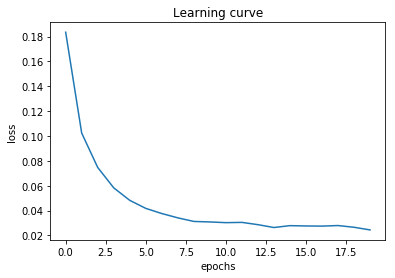

Stored 'y_pred' (ndarray)


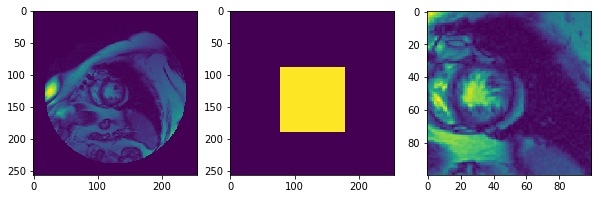

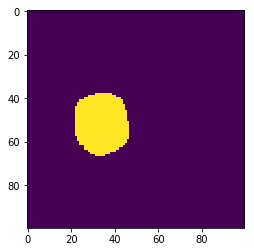

In [3]:
%run 'CNN.ipynb'

## Stacked auto-encoder

### 1rst part : another representation of the ROI with sparse auto-encoder

In [4]:
%store -r y_pred

In [5]:
input_AE = [] #images (100,100)
for j in range(y_pred.shape[0]):
    input_AE.append(cv2.resize(compute_roi_pred(y_pred, j, roi_shape=32)[0],(64 , 64)))
input_AE = np.asarray(input_AE).reshape((-1, 64*64)) #unrolled : 64*64 = vector of 4096 elements

#### Model

In [6]:
from keras import losses
def customized_loss(y_true, y_pred):
    #customize your own loss components
    loss1 = losses.mean_absolute_error(y_true, y_pred)
    loss2 = losses.kullback_leibler_divergence(y_true, y_pred)
    #adjust the weight between loss components
    return 0.0001*0.5 * loss1 + 3 * loss2

In [7]:
model = Sequential()
model.add(Dense(100, kernel_regularizer=regularizers.l2(3*0.001), input_shape=[input_AE.shape[1]]))
model.add(Dense(4096, kernel_regularizer=regularizers.l2(3*0.001)))

In [8]:
for p in model.layers:
    print(p.name, p.input_shape, p.output_shape)

dense_2 (None, 4096) (None, 100)
dense_3 (None, 100) (None, 4096)


#### Training

In [9]:
model.compile(loss= customized_loss,
              optimizer='adam')

In [10]:
h = model.fit(input_AE, input_AE, epochs=100, verbose=2)

Epoch 1/100
1s - loss: 66267.0560
Epoch 2/100
0s - loss: 20767.9276
Epoch 3/100
0s - loss: 18151.3171
Epoch 4/100
0s - loss: 18036.2644
Epoch 5/100
0s - loss: 17943.6509
Epoch 6/100
0s - loss: 17751.6437
Epoch 7/100
0s - loss: 17602.6277
Epoch 8/100
0s - loss: 17505.9282
Epoch 9/100
0s - loss: 17389.7354
Epoch 10/100
0s - loss: 17235.2564
Epoch 11/100
0s - loss: 17199.8263
Epoch 12/100
0s - loss: 17198.1836
Epoch 13/100
0s - loss: 17177.1363
Epoch 14/100
0s - loss: 17186.2236
Epoch 15/100
0s - loss: 17215.8961
Epoch 16/100
0s - loss: 17172.5188
Epoch 17/100
0s - loss: 17229.4267
Epoch 18/100
0s - loss: 17179.3134
Epoch 19/100
0s - loss: 17109.9997
Epoch 20/100
0s - loss: 17089.4362
Epoch 21/100
0s - loss: 17092.3791
Epoch 22/100
0s - loss: 17084.6678
Epoch 23/100
0s - loss: 17093.8116
Epoch 24/100
0s - loss: 17103.3500
Epoch 25/100
0s - loss: 17069.1941
Epoch 26/100
0s - loss: 17070.1753
Epoch 27/100
0s - loss: 17045.6573
Epoch 28/100
0s - loss: 17041.9315
Epoch 29/100
0s - loss: 17027

Text(0.5,0,'epochs')

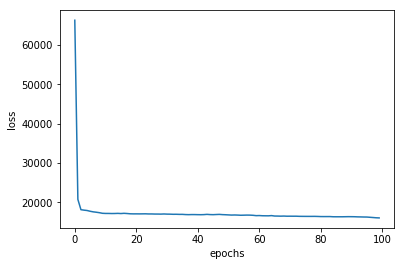

In [11]:
metric = 'loss'
plt.plot(range(len(h.history[metric])), h.history[metric])
plt.ylabel(metric)
plt.xlabel('epochs')

#### Prediction

In [17]:
input_AE_pred = model.predict(input_AE)

In [18]:
pred = input_AE_pred[0].reshape(64, 64)

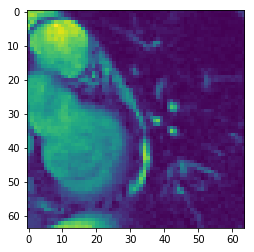

In [19]:
plt.imshow(input_AE[0].reshape(64,64))

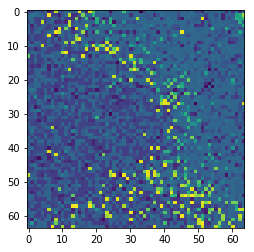

In [20]:
plt.imshow(pred)

### 2nd part : From new representation of ROI to inferred shape using annotated contours

In [21]:
_,_, mask_contour = compute_roi_pred(y_pred, 234)

In [22]:
contour_experts = [] #images (100,100)
for j in range(y_pred.shape[0]):
    contour_experts.append(cv2.resize(compute_roi_pred(y_pred, j)[2], (64,64), interpolation = cv2.INTERSECT_NONE))
contour_experts = np.asarray(contour_experts).reshape((-1, 64*64)) #unrolled : 64*64 = vector of 4096 elements

In [23]:
input_y = contour_experts
input_x = input_AE#_pred

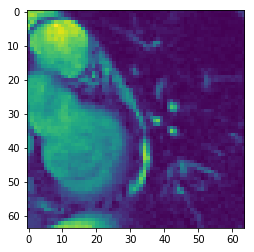

In [24]:
plt.imshow(input_AE[0].reshape(64,64))

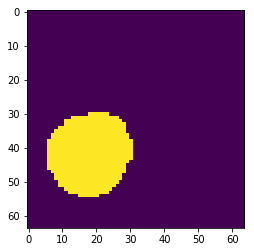

In [25]:
plt.imshow(contour_experts[0].reshape(64,64))

In [39]:
model = Sequential()
model.add(Dense(100, kernel_regularizer=regularizers.l2(3*0.001), input_shape=[input_AE.shape[1]]))
model.add(Dense(100, kernel_regularizer=regularizers.l2(3*0.001)))
model.add(Dense(4096, kernel_regularizer=regularizers.l2(3*0.001)))
#model.add(Dense(4096,  input_shape=[l2.shape[1]*l2.shape[2]]))
#model.add(Dense(100, input_shape=[l2.shape[1]]))

In [40]:
for p in model.layers:
    print(p.name, p.input_shape, p.output_shape)

dense_7 (None, 4096) (None, 100)
dense_8 (None, 100) (None, 100)
dense_9 (None, 100) (None, 4096)


In [41]:
model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['accuracy'])

In [42]:
h2 = model.fit(input_x, input_y, epochs=50, verbose=2)

Epoch 1/50
1s - loss: 1681.1789 - acc: 0.0000e+00
Epoch 2/50
0s - loss: 283.0521 - acc: 0.0000e+00
Epoch 3/50
0s - loss: 139.9157 - acc: 0.0000e+00
Epoch 4/50
0s - loss: 89.1359 - acc: 0.0000e+00
Epoch 5/50
0s - loss: 64.2143 - acc: 0.0000e+00
Epoch 6/50
0s - loss: 52.8758 - acc: 0.0000e+00
Epoch 7/50
0s - loss: 43.8810 - acc: 0.0000e+00
Epoch 8/50
0s - loss: 37.8875 - acc: 0.0000e+00
Epoch 9/50
0s - loss: 33.3498 - acc: 0.0000e+00
Epoch 10/50
0s - loss: 28.6330 - acc: 0.0000e+00
Epoch 11/50
0s - loss: 24.7734 - acc: 0.0000e+00
Epoch 12/50
0s - loss: 22.4124 - acc: 0.0000e+00
Epoch 13/50
0s - loss: 21.9354 - acc: 0.0000e+00
Epoch 14/50
0s - loss: 19.9303 - acc: 0.0000e+00
Epoch 15/50
0s - loss: 17.5280 - acc: 0.0000e+00
Epoch 16/50
0s - loss: 16.2476 - acc: 0.0000e+00
Epoch 17/50
0s - loss: 16.1034 - acc: 0.0000e+00
Epoch 18/50
0s - loss: 21.9309 - acc: 0.0000e+00
Epoch 19/50
0s - loss: 17.8268 - acc: 0.0000e+00
Epoch 20/50
0s - loss: 14.0896 - acc: 0.0000e+00
Epoch 21/50
0s - loss: 11

Text(0.5,0,'epochs')

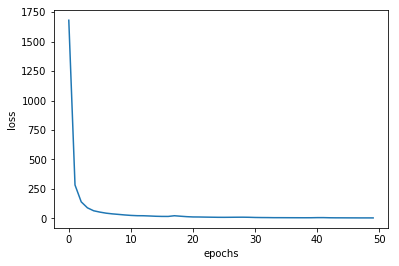

In [43]:
metric = 'loss'
plt.plot(range(len(h2.history[metric])), h2.history[metric])
plt.ylabel(metric)
plt.xlabel('epochs')

In [44]:
l3_pred = model.predict(input_x)

In [45]:
pred3 = l3_pred[0].reshape(64, 64)

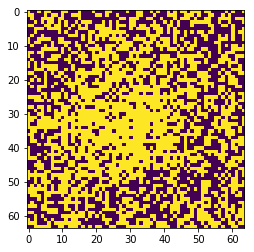

In [54]:
j = 17
# select one predicted ROI
pred3 = l3_pred[j].reshape((64,64))
p = cv2.threshold(pred3, 0, 1, cv2.THRESH_BINARY)
plt.imshow(p[1])

In [55]:
pred3

array([[ 1.62608647, -0.22405949, -1.70112824, ..., -0.40606561,
        -0.97822291,  0.27963597],
       [ 0.65292394,  0.47169495, -0.97112972, ..., -3.83251977,
        -1.32044208, -1.69579458],
       [-0.19820568,  0.30238515, -0.33653802, ...,  0.16548884,
         0.18447563,  0.68743587],
       ..., 
       [ 0.28474405, -0.53380585,  0.41408145, ...,  0.78451014,
        -0.2951192 ,  2.33391953],
       [ 1.0306325 ,  0.11533707,  1.31229627, ..., -1.0337497 ,
         1.08634257,  0.04784082],
       [-1.16911519, -2.46504807,  0.64478564, ...,  0.16694066,
        -0.44659007, -0.11908283]], dtype=float32)

In [56]:
#pred3>0

2e stacked auto encoder ne fonctionne pas

In [ ]:
#opt_solution   = scipy.optimize.minimize(encoder1.sparseAutoencoderCost, encoder1.theta, 
#                                             args = (train_data,), method = 'L-BFGS-B', 
#                                             jac = True, options 